# Time series Forecasting of Air Passenger dataset

In [1]:
# import the necessary libraries
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
#!pip install pmdarima --quiet
import pmdarima as pm

Loading data

Air Passenger Dataset. 

This dataset contains the number of air travel passengers from the start of 1949 to the end of 1960.

This dataset has a positive trend and annual seasonality.

In [2]:
# laoding data
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")
df.head()


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
df.shape

(144, 2)

In [5]:
# set date as index
df["Month"] = pd.to_datetime(df["Month"],infer_datetime_format=True)
df = df.set_index(["Month"])
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


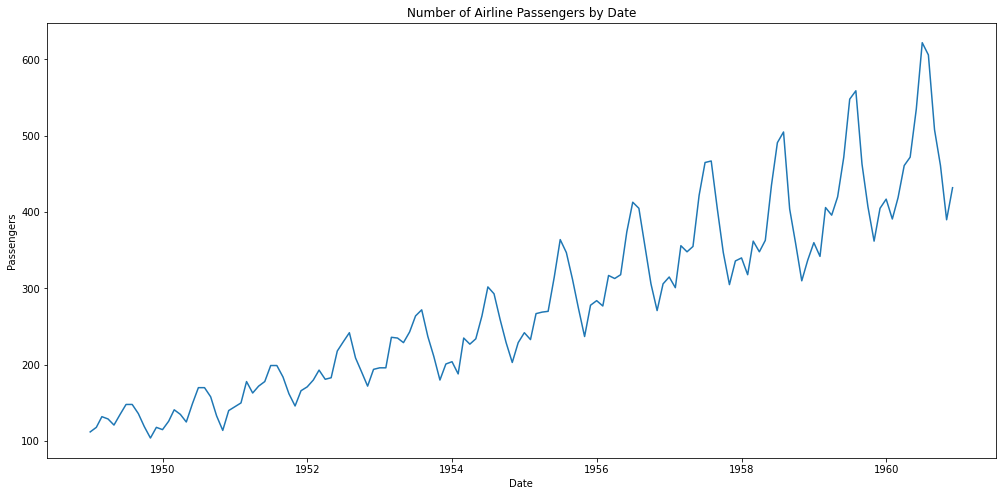

In [6]:
# visualizing the data
plt.figure(figsize=(17,8))
plt.plot(df)
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.title("Number of Airline Passengers by Date")
plt.show()

At first glance, there looks to be a positive trend and some sort of seasonality or cyclicity in the dataset. There does not appear to be any major irregularities or noise in the data.

# Rolling Statistics

A rolling average is a great way to visualize how the dataset is trending. As the dataset provides counts by month, a window size of 12 will give us the annual rolling average.

We will also include the rolling standard deviation to see how much the data varies from the rolling average.

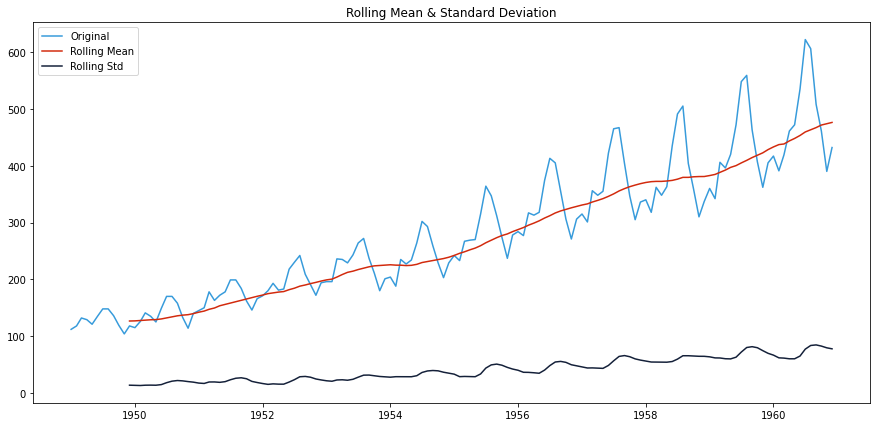

In [11]:
# Determine rolling statistics
df["rolling_avg"] = df["#Passengers"].rolling(window=12).mean() 
# window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["#Passengers"].rolling(window=12).std()

#plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["#Passengers"], color="#379BDB", label = "Original")
plt.plot(df["rolling_avg"], color = "#D22A0D", label = "Rolling Mean")
plt.plot(df["rolling_std"], color = "#142039", label = "Rolling Std")
plt.legend(loc = "best")
plt.title("Rolling Mean & Standard Deviation")
plt.show(block = False)

# Augmented Dickey–Fuller Test
The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not. Similar to a t-test, we set a significance level before the test and make conclusions on the hypothesis based on the resulting p-value.

p-value <= significance level (0.01, 0.05, 0.10, etc.)


If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

In [14]:
# Augmented Dickey-Fuller test:
print("Result of Dickey Fuller Test: ")
dftest = adfuller(df["#Passengers"], autolag = "AIC")

dfoutput = pd.Series(dftest[0:4], index = ["Test Statistics", "p-value",
                                           "#Lags Used", "Number of observation Used"])
for key,value in dftest[4].items():
    dfoutput["Critical value (%s) "%key] = value
    
print(dfoutput)
                     

Result of Dickey Fuller Test: 
Test Statistics                 0.815369
p-value                         0.991880
#Lags Used                     13.000000
Number of observation Used    130.000000
Critical value (1%)            -3.481682
Critical value (5%)            -2.884042
Critical value (10%)           -2.578770
dtype: float64


We can see in the ADF test that the p-value is 0.991880, meaning that it is very likely that the data is not stationary.

# ARIMA Model Selection w/ Auto-ARIMA
Although our data is almost certainly not stationary (p-value = 0.991), let’s see how well a standard ARIMA model performs on the time series

Using the auto_arima() function from the pmdarima package, we can perform a parameter search for the optimal values of the model.

In [19]:
# Standard ARIMA Model
ARIMA_Model = pm.auto_arima(df["#Passengers"],
                            start_p=1,
                            start_q=1,
                            test = "adf", # use adftest to find optimal "d"
                            max_p = 3, max_q = 3, # maximum p and q
                            m = 1 , # frequency of series (if m==1, seasonal is set to FALSE automatically)
                            d = None, # let model determine "d"
                            seasonal = False, # No Seasonality for standard ARIMA
                            trace = False, # logs
                            error_action = "warn", # shows error('ignore' silences these)
                            suppress_warnings= True,
                            stepwise=True)

In [22]:
ARIMA_Model

ARIMA(order=(2, 0, 1), scoring_args={}, suppress_warnings=True)

# Model Diagnostics
Four plots result from the plot_diagnostics function. The Standardized residual, Histogram plus KDE estimate, Normal q-q, and the correlogram.

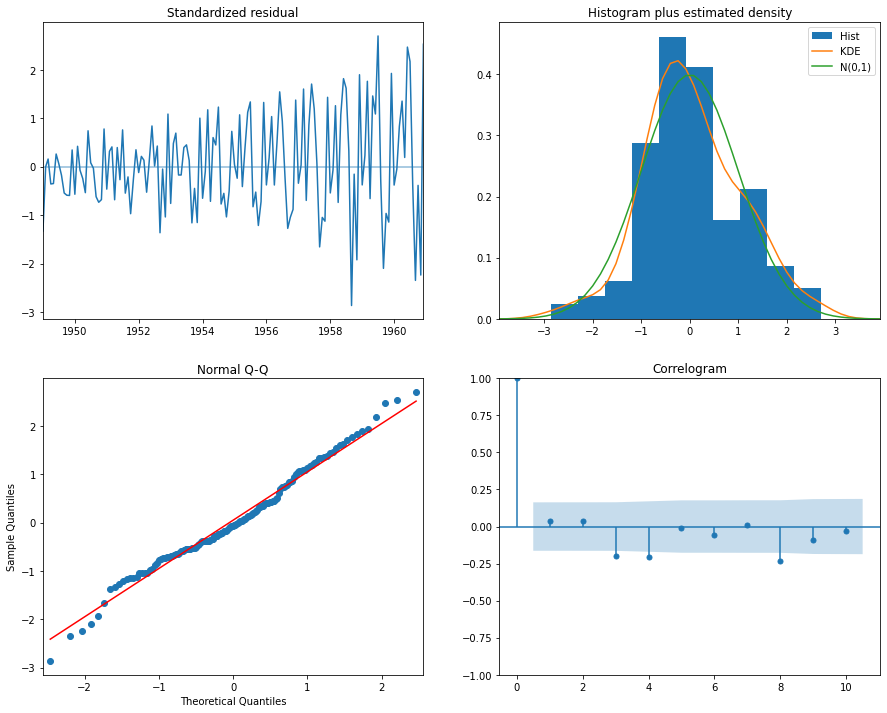

In [24]:
ARIMA_Model.plot_diagnostics(figsize =(15,12))
plt.show()

We can interpret the model as a good fit based on the following conditions.

Standardized residual

There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.

Histogram plus KDE estimate

The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)

Normal Q-Q

Most of the data points should lie on the straight line

Correlogram (ACF plot)

95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a few values outside of this area, and therefore we may need to add more predictors to make the model more accurate

We can then use the model to forecast airline passenger counts over the next 24 months.

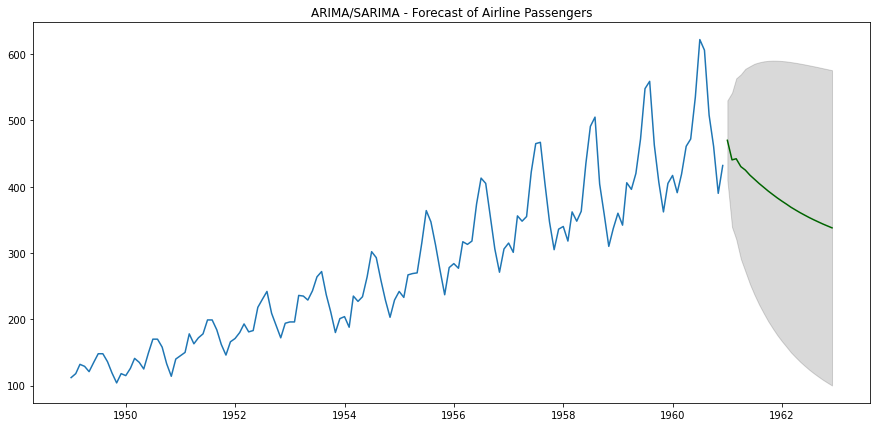

In [33]:
def forecast(ARIMA_model, periods = 24):
    # forecast 
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods = n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1),periods=n_periods,freq="MS")
    
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series =  pd.Series(confint[:,0], index = index_of_fc)
    upper_series = pd.Series(confint[:,1], index = index_of_fc)
    
    # plot
    plt.figure(figsize=(15,7))
    plt.plot(df["#Passengers"],color="#1f76b4")
    plt.plot(fitted_series,color="darkgreen")
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color="k",alpha=0.15)
    
    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.show()
    
forecast(ARIMA_Model)

As we can see from the plot, this doesn’t seem to be a very accurate forecast. Maybe we need to change the model structure so that it takes into account seasonality?

# SARIMA Model
Now let’s try the same strategy as we did above, except let’s use a SARIMA model so that we can account for seasonality.

In [35]:
# seasonal - fit setwise auto-ARIMA
SARIMA_model = pm.auto_arima(df["#Passengers"],
                                start_p=1,
                                start_q=1,
                                test="adf",
                                max_p=3,max_q=3,
                                m=12, # 12 is the frequency of cycle
                                start_P = 0,
                                seasonal=True, # set the seasonal
                                d=None,
                                D = 1, # order of the seasonal differencing
                                trace = False,
                                error_action = 'ignore',
                                suppress_warinings = True,
                                stepwise = True)
                                

In [37]:
SARIMA_model

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

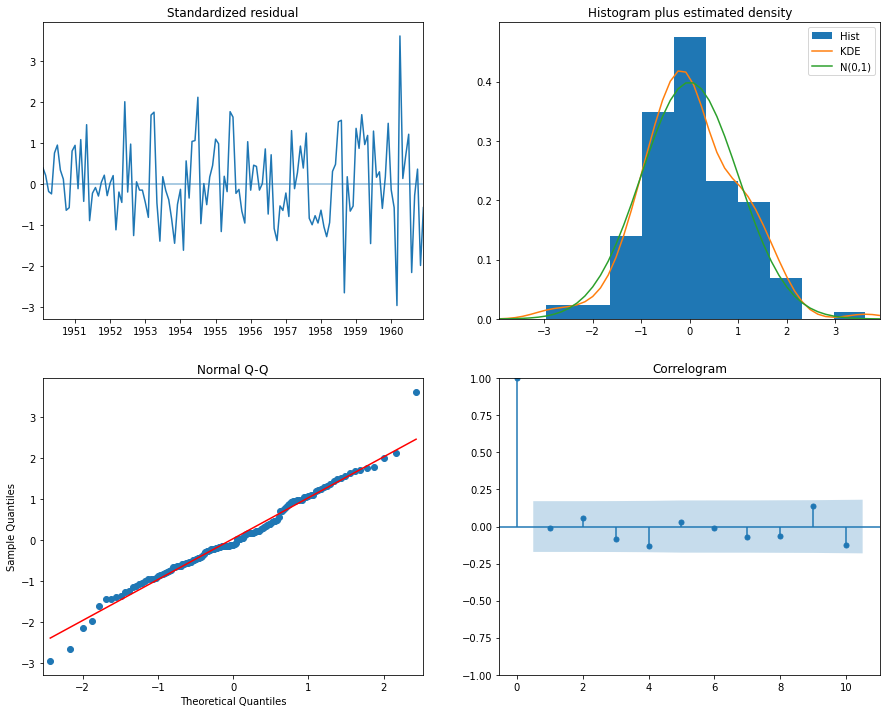

In [39]:
# model diagonostics of SARIMA_model
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

Taking a look at the model diagnostics, we can see some significant differences when compared with the standard ARIMA model.

Standardized residual

The Standardized residual is much more consistent across the graph, meaning that the data is closer to being stationary.

Histogram plus KDE estimate

The KDE curve is similar to the normal distribution (not much changed here).

Normal Q-Q

The data points are clustered much closer to the line than in the ARIMA diagnostic plot.

Correlogram (ACF plot)

The grey area is the confidence band, and if values fall outside of this then they are statistically significant. We want all values inside this area. Adding the seasonality component did this! All the points now fall within the 95% confidence interval.



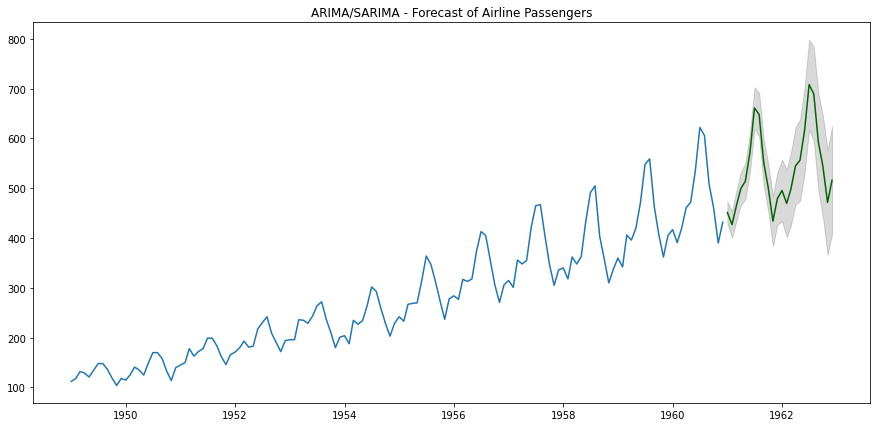

In [40]:
# we can use the model to forecast airline passegers counts ove the 
# next 24 months as we did before
forecast(SARIMA_model)

As we can see from the plot below, this seems to be much more accurate than the standard ARIMA model!

# SARIMAX Model Selection

adding in an exogenous variable. simply going to add the month number as an exogenous varible, but this is not super useful as this is already conveyed through the seasonality.

In [42]:
# adding exogenous variable
df["month_index"] = df.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df[["#Passengers"]], exogenous=df[["month_index"]],
                              start_p = 1, start_q = 1,
                              test = "adf",
                              max_p = 3, max_q = 3, m = 12,
                              start_P = 0, seasonal=True,
                              d = None, D = 1,
                              trace = False,
                              error_action = 'ignore',
                              suppress_warnings=True,
                              stepwise=True)



                                 

In [45]:
SARIMAX_model


ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

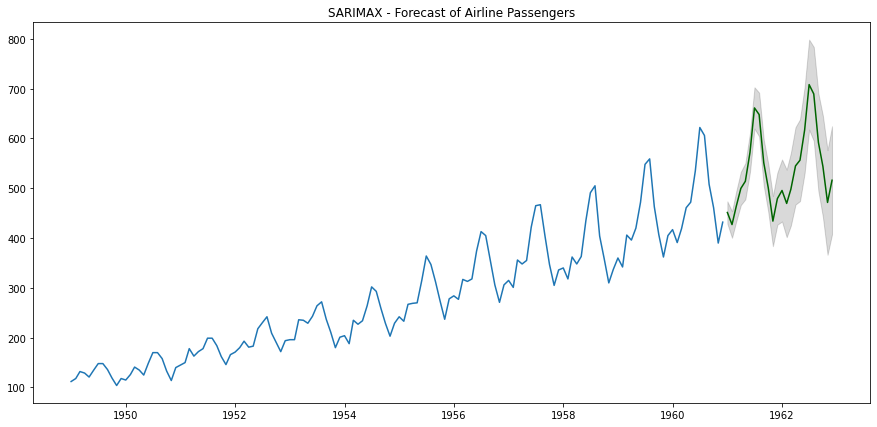

In [47]:
def sarimax_forecast(SARIMAX_model, periods = 24):
    # forecast
    n_periods = periods
    
    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq = "MS").month},
                               index = pd.date_range(df.index[-1] + pd.DateOffset(months = 1) , periods = n_periods, freq = "MS"))
    
    fitted, confint = SARIMAX_model.predict(n_periods = n_periods,
                                            return_conf_int = True,
                                            exogenous = forecast_df[["month_index"]])
    
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months = 1), periods = n_periods, freq="MS")
    
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:,0], index = index_of_fc)
    upper_series = pd.Series(confint[:,1], index = index_of_fc)
    
    
    
    # plot
    plt.figure(figsize = (15,7))
    plt.plot(df["#Passengers"], color= "#1f76b4")
    plt.plot(fitted_series, color="darkgreen")
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha = 0.15)
    
    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()
    
sarimax_forecast(SARIMAX_model, periods = 24)
    

We can see from the following predictions that we are getting some pretty good-looking predictions and the width of the forecasted confidence interval has decreased. This means that the model is more certain of its predictions.